In [2]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from matplotlib import patches as mpatches
import sys
sys.path.append('../../../src/')

import os

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, ttest_rel
import plotting_friction_experiment as f
from scipy import stats

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 4 - manipulating cost of travelling and global statistics\results'

palette = {
    'control': 'grey',  # Red
    'friction_high': '#6a51a3',  # Purple
    'friction_med': '#807dba',  # Lighter Purple
    'friction_low': '#9e9ac8',  # Lightest Purple
    'distance_extra_short': 'crimson',  # Blue
    'distance_short': 'pink',  # Lighter Blue
    'distance_extra_long': '#fd8d3c',  # Yellow
    'distance_long': '#fdae6b'  # Lighter Yellow
}

sns.set_context('talk')



### **Retrieving and preparing the data**

In [33]:
print('Loading')
summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'), index_col=0)

summary_df['perceived_reward_probability'] = summary_df['cumulative_rewards'] / (summary_df['visit_number'] +1)

summary_df = summary_df.loc[summary_df.experiment.isin(['friction', 'control', 'distance_long', 'distance_short', 'friction_low','friction_med', 'friction_high', 'distance_extra_long', 'distance_extra_short'])]

## These mice are in the dataset but didn't perform the manipulation
summary_df = summary_df[(summary_df['mouse'] != 754573)&(summary_df['mouse'] != 754572)&(summary_df['mouse'] != 745300)&(summary_df['mouse'] != 745306)&(summary_df['mouse'] != 745307)]

Loading


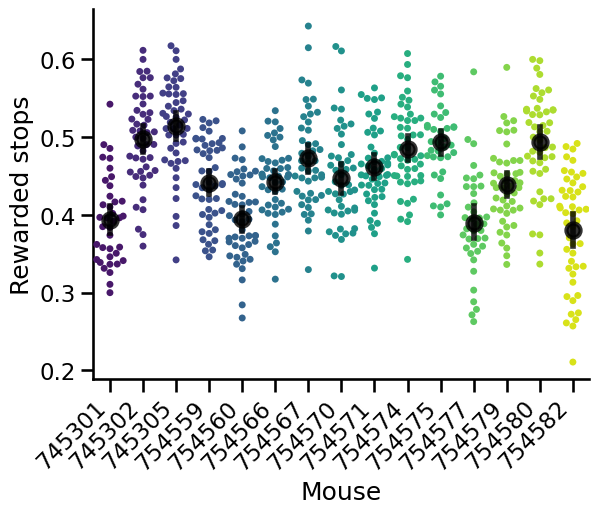

In [67]:
test_df = summary_df.loc[(summary_df.visit_number > 0)|(summary_df.odor_label =='Amyl Acetate')].groupby(['mouse', 'session']).agg({'active_patch': 'nunique', 'has_choice': 'sum', 'reward_delivered': 'sum'}).reset_index()
test_df['ratio'] = test_df['reward_delivered'] / (test_df['has_choice'])

sns.swarmplot(data=test_df, x='mouse', y='ratio', palette='viridis')
sns.pointplot(data=test_df, x='mouse', y='ratio', color='black', join=False, estimator=np.mean, zorder=10, alpha=0.8)

plt.xlabel('Mouse')
plt.ylabel('Rewarded stops')
plt.xticks(rotation=45, ha='right')
sns.despine()

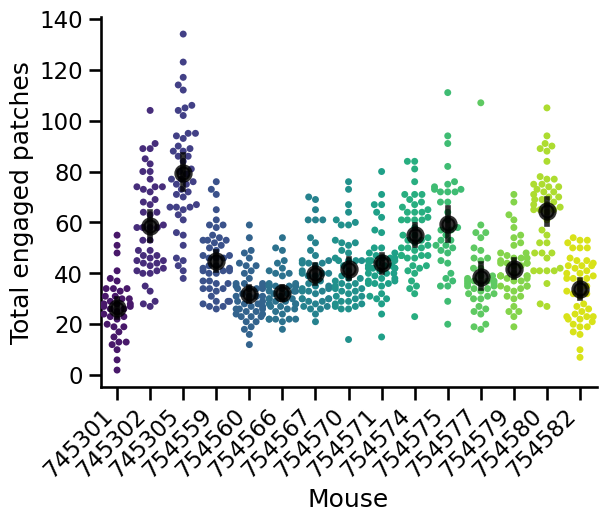

In [63]:
sns.swarmplot(data=test_df, x='mouse', y='active_patch', palette='viridis')
sns.pointplot(data=test_df, x='mouse', y='active_patch', color='black', join=False, estimator=np.mean, zorder=10, alpha=0.8)

plt.xlabel('Mouse')
plt.ylabel('Total engaged patches')
plt.xticks(rotation=45, ha='right')
sns.despine()

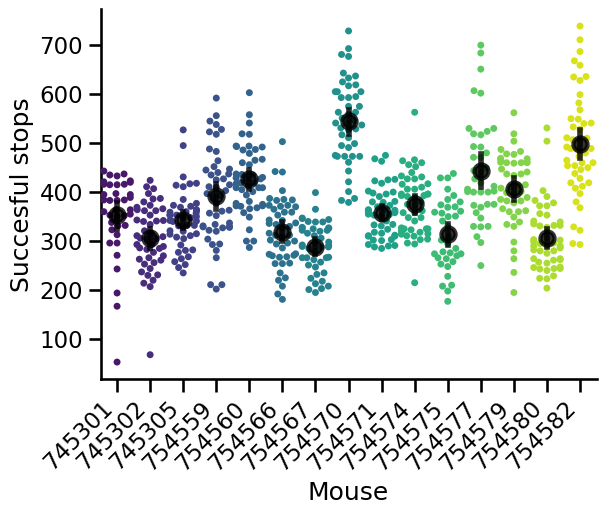

In [61]:
sns.swarmplot(data=test_df, x='mouse', y='has_choice', palette='viridis')
sns.pointplot(data=test_df, x='mouse', y='has_choice', color='black', join=False, estimator=np.mean, zorder=10, alpha=0.8)

plt.xlabel('Mouse')
plt.ylabel('Succesful stops')
plt.xticks(rotation=45, ha='right')
sns.despine()

Prepare the three main dataframes that we are going to use throughout the notebook
* **mouse_df** = mouse specific dataframe with the data for each session, you have every patch. 
* session_df = summarize each session for each mouse, collapse the patches
* general_df = Summarizes all information for each mouse, collapses sessions and patches

In [ ]:
groups = ['session', 'session_n','mouse','active_patch','odor_label','experiment', 'rig']

#Relabelling the sessions using the torque calibration
# summary_df['experiment'] = summary_df['experiment_torque']

pre_df = summary_df[(summary_df['engaged'] == True)|(summary_df['active_patch'] <= 20)]

# pre_df = pre_df.loc[(pre_df.mouse != 754577)&(pre_df.mouse != 754575)]
# These df summarizes each patch for each session for each mouse
mouse_df = (
    pre_df.loc[(pre_df.visit_number > 0) & (pre_df.last_site == 1)]
    .groupby(groups)
    .agg(
        visit_number=('visit_number', 'max'),
        reward_probability=('reward_probability', 'min'),
        stops=('visit_number', 'max'),
        total_rewards=('cumulative_rewards', 'max'),
        consecutive_rewards = ('consecutive_rewards', 'max'),
        total_failures=('cumulative_failures', 'max'),
        consecutive_failures = ('consecutive_failures', 'max'), 
        friction=('torque_friction', 'max'),
    )
    .reset_index()
)
mouse_df['total_water'] = mouse_df['total_rewards']*5
groups.pop(groups.index('active_patch'))

# These df summarizes each session for each mouse (averages patches within session)
session_df = ( 
        mouse_df
        .groupby(groups)
        .agg(visit_number = ('visit_number','sum'), 
              reward_probability = ('reward_probability','mean'), 
              stops = ('stops','mean'),
              total_stops = ('stops','sum'), 
              total_rewards = ('total_rewards','mean'),
              consecutive_rewards = ('consecutive_rewards','mean'),
              total_failures = ('total_failures','mean'),
              consecutive_failures = ('consecutive_failures','mean'), 
              active_patch = ('active_patch','nunique'), 
              total_water = ('total_water','sum'),
              friction = ('friction', 'mean'))
        .reset_index()
)

groups.pop(groups.index('session_n'))
# groups.pop(groups.index('within_session_n'))

# These df summarizes metrics for each mouse (averages all sessions and all patches withing that session)
general_df = ( 
        mouse_df
        .groupby(['mouse','odor_label', 'experiment'])
        .agg({'visit_number':'mean', 
              'reward_probability':'mean', 
              'stops':'mean', 
              'total_rewards':'mean',
              'consecutive_rewards':'mean',
              'total_failures':'mean',
              'consecutive_failures':'mean', 
              'active_patch':'mean'
              })
        .reset_index()
)

In [67]:
mouse_df.to_csv(os.path.join(data_path, 'batch_4_mouse_df.csv'))
session_df.to_csv(os.path.join(data_path, 'batch_4_session_df.csv'))

### Summary of main variables across mice and overall summary

In [ ]:
for experiment in summary_df.experiment.unique():
    with PdfPages(results_path+f'/summary_results_{experiment}_per_mouse.pdf') as pdf:
        for mouse in session_df.mouse.unique():
            print(mouse)
            f.summary_main_variables(session_df.loc[session_df.mouse == mouse], experiment, condition='session_n', save=pdf)

In [ ]:
for experiment in general_df.experiment.unique():
    with PdfPages(results_path+f'/summary_general_results_{experiment}_all.pdf') as pdf:
        f.summary_main_variables(general_df, experiment, condition='mouse', save=pdf)

## Across sessions dynamics

In [ ]:
for variable in ['reward_probability', 'stops', 'total_rewards', 'consecutive_rewards', 'total_failures', 'consecutive_failures', 'active_patch', 'total_water']:
    with PdfPages(results_path+f'/across_sessions_{variable}.pdf') as pdf:
        f.across_sessions_one_plot(session_df.loc[session_df.odor_label != 'Amyl Acetate'], variable, save=pdf)

## Main variables compared across experiments

In [ ]:
def plot_simple_experiments(ax, summary_df, variable, experiments= ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long', 'distance_extra_short', 'distance_extra_long']):
    labels_dict = {'control': 'Control', 'friction_low': 'Friction low', 'friction_med': 'Friction med', 'friction_high': 'Friction high', 'distance_short': 'Dis. short', 'distance_long': 'Dis. long', 'distance_extra_short': 'Ext. short', 'distance_extra_long': 'Ext. long'}
    
    summary_df = summary_df.loc[summary_df.odor_label != 'Amyl Acetate']
    summary_df = summary_df.groupby(['experiment', 'mouse']).agg({variable:'mean'}).reset_index()
    # Adjust the linewidth or dodge parameter based on experiment_width
    sns.boxplot(x='experiment', y=variable, legend=False,
                data=summary_df, palette=palette,
                showfliers=False, ax=ax,  order= ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short',  'distance_extra_short', 'distance_long','distance_extra_long'])  # Example adjustment
    sns.swarmplot(x='experiment', y=variable, legend=False, color='black', data=summary_df, dodge=True, ax=ax, order=['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short','distance_extra_short', 'distance_long',  'distance_extra_long'])
    
    for experiment in experiments:
        labels_plot = [labels_dict[experiment] for experiment in experiments]
        
    ax.set_xticks(np.arange(len(experiments)), labels_plot, rotation = 45, ha='right')
    
    # Additional plot adjustments
    ax.set_title(f'All')
    ax.hlines(summary_df.loc[(summary_df.experiment == 'control')][variable].mean(), -0.5, 5.5, linestyles='dashed', alpha=0.5, color='grey')
    ax.set_xlabel('')
    if variable == 'reward_probability':
        ax.set_yticks([0, 0.2, 0.4, 0.6])
        ax.set_ylim(0, 0.6)
        ax.set_ylabel('p(reward) when leaving')
    if variable == 'stops':
        ax.set_ylim(0, 50)
    sns.despine()
    plt.tight_layout()

In [ ]:
def plot_simple_experiments_odors(ax, summary_df, variable, experiments= ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long', 'distance_extra_short', 'distance_extra_long']):
    labels_dict = {'control': 'Control', 'friction_low': 'Friction low', 'friction_med': 'Friction med', 'friction_high': 'Friction high', 'distance_short': 'Dis. short', 'distance_long': 'Dis. long', 'distance_extra_short': 'Ext. short', 'distance_extra_long': 'Ext. long'}
    
    summary_df = summary_df.loc[summary_df.odor_label != 'Amyl Acetate']

    # Adjust the linewidth or dodge parameter based on experiment_width
    sns.boxplot(x='experiment', y=variable, hue='odor_label', legend=False,
                palette=color_dict_label, data=summary_df,
                showfliers=False, ax=ax,  order=experiments)  # Example adjustment
    sns.swarmplot(x='experiment', y=variable, hue='odor_label', legend=False, data=summary_df, dodge=True, palette=color_dict_label, ax=ax, order=experiments)
    # Additional plot adjustments
    ax.set_title(f'All')
    for experiment in experiments:
        labels_plot = [labels_dict[experiment] for experiment in experiments]
        
    ax.set_xticks(np.arange(len(experiments)), labels_plot, rotation = 45, ha='right')
    ax.hlines(summary_df.loc[(summary_df.experiment == 'control')][variable].mean(), -0.5, len(experiments)-0.5, linestyles='dashed', alpha=0.5, color='grey')
    ax.set_xlabel('')
    if variable == 'reward_probability':
        ax.set_yticks([0, 0.2, 0.4, 0.6])
        ax.set_ylim(0, 0.6)
        ax.set_ylabel('p(reward) when leaving')
    if variable == 'stops':
        ax.set_ylim(0, 50)
    sns.despine()
    plt.tight_layout()


In [ ]:
def plot_simple_experiments_mouse(session_df, variable, save=False, experiments= ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long', 'distance_extra_short', 'distance_extra_long']):
    labels_dict = {'control': 'Control', 'friction_low': 'Friction low', 'friction_med': 'Friction med', 'friction_high': 'Friction high', 'distance_short': 'Dis. short', 'distance_long': 'Dis. long', 'distance_extra_short': 'Ext. short', 'distance_extra_long': 'Ext. long'}
    # Assuming 'summary' is your DataFrame
    # Calculate the dynamic widths
    widths = summary_df.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
    widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

    fig, axes = plt.subplots(5,3, figsize=(16, 30), sharey=True)
    session_df = session_df.loc[session_df.odor_label != 'Amyl Acetate']
    for (i, mouse), ax in zip(enumerate(session_df.mouse.unique()), axes.flatten()):
        
        # Get the dynamic width for this mouse
        mouse_widths = widths.loc[mouse]
        
        # Plot each experiment with adjusted widths
        for experiment in experiments:
            # Calculate the width for this experiment
            if session_df.loc[(session_df.experiment == experiment)].empty:
                continue
            
            experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
            if experiment == 'control':
                # specific_df = session_df.loc[(session_df.within_session_number >5)]
                specific_df = session_df.loc[(session_df.experiment == experiment)&(session_df.mouse == mouse)]
            else:
                specific_df = session_df.loc[(session_df.experiment == experiment)&(session_df.mouse == mouse)]
            # Adjust the linewidth or dodge parameter based on experiment_width
            sns.boxplot(x='experiment', y=variable, hue='odor_label', legend=False,
                        palette=color_dict_label, data=specific_df,
                        showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=experiments)  # Example adjustment
            sns.swarmplot(x='experiment', y=variable, hue='odor_label', legend=False,
                        palette=color_dict_label, dodge = True, data=specific_df,
                         ax=ax)  # Example adjustment
        # Additional plot adjustments
        ax.set_title(f'{mouse}')
        for experiment in experiments:
            labels_plot = [labels_dict[experiment] for experiment in experiments]
            
        ax.set_xticks(np.arange(len(experiments)), labels_plot, rotation = 45, ha='right')
        ax.hlines(session_df.loc[(session_df.experiment == 'control')&(session_df.mouse == mouse)][variable].mean(), -0.5, len(experiments), linestyles='dashed', alpha=0.5, color='grey')
        ax.set_xlabel('')
        sns.despine()

        if variable == 'reward_probability':
            ax.set_yticks([0, 0.2, 0.4, 0.6])
            ax.set_ylim(0, 0.6)
            ax.set_ylabel('p(reward) when leaving')
        if variable == 'stops':
            ax.set_ylim(0, 50)
        
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig(save, format='pdf')

In [ ]:
def plot_experiment_comparison(df, variable, ax=None):
    """Plot boxplots with significance stars comparing experiments"""
    exps = [ 'control',  'friction_low',  'friction_med', 'friction_high']
    # Create figure if no axis provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    # Create boxplot
    sns.boxplot(data=df, x='experiment', y=variable, hue='odor_label', palette=color_dict_label,
                order=exps,
                showfliers=False, ax=ax)
    
    
    # Perform statistical tests
    control_data = df[df['experiment']=='control'][variable]
    pairs = []
    p_values = []
    
    # Compare each experiment to control
    for exp in exps:
        exp_data = df[df['experiment']==exp][variable]
        stat, p = stats.ttest_rel(control_data, exp_data)
        pairs.append(('control', exp))
        p_values.append(p)
    
    # Add significance annotations
    y_max = df[variable].max()
    y_pos = y_max + (y_max * 0.01)
    print(pairs, p_values)
    for i, (pair, p) in enumerate(zip(pairs, p_values)):
        if p < 0.001:
            star = '***'
        elif p < 0.01:
            star = '**' 
        elif p < 0.05:
            star = '*'
        else:
            continue
            
        # x1 = ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long'].index(pair[0])
        # x2 = ['control', 'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long'].index(pair[1])
        
        x1 = exps.index(pair[0])
        x2 = exps.index(pair[1])       
        ax.plot([x1, x2], [y_pos, y_pos], 'k-', linewidth=1)
        ax.text((x1 + x2)/2, y_pos, star, ha='center', va='bottom')
        y_pos += y_max * 0.1
    
    # Customize plot
    ax.set_xlabel('')
    # ax.set_xticklabels(['Control', 'Friction', 'Dis. short', 'Dis. long'], rotation=45)
    ax.set_ylabel(variable)
    sns.despine()
    
    return ax

# Example usage:
fig, ax = plt.subplots(figsize=(8, 6))
plot_experiment_comparison(general_df.loc[general_df.odor_label != 'Amyl Acetate'], 'reward_probability', ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
def plot_experiment_comparison(df, variable, ax=None):
    """Plot boxplots with significance stars comparing experiments"""
    
    # Create figure if no axis provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create boxplot
    sns.boxplot(data=df, x='experiment', y=variable, hue='odor_label', palette=color_dict_label,
                order=[ 'control',  'friction_low', 'friction_med', 'friction_high', 'distance_short', 'distance_long', 'distance_extra_short', 'distance_extra_long'],
                showfliers=False, ax=ax)
    plt.hlines(df.loc[df.experiment=='control'][variable].mean(), -0.5, 7.5, linestyles='dashed', alpha=0.5, color='black')
    # Customize plot
    ax.set_xlabel('')
    ax.set_xticklabels(['Control', 'FR. low', 'FR. med', 'FR. high', 'Dis. short', 'Dis. long', 'extra short', 'extra long'], rotation=45)
    ax.set_ylabel(variable)
    sns.despine()
    
    return ax

# Example usage:
fig, ax = plt.subplots(figsize=(10, 5))
plot_experiment_comparison(general_df.loc[general_df.odor_label != 'Amyl Acetate'], 'reward_probability', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [ ]:
with PdfPages(results_path+f'/summary_general_results_across_experiments.pdf') as pdf:
    for variable in ['reward_probability', 'stops', 'total_rewards', 'consecutive_rewards', 'total_failures', 'consecutive_failures', 'active_patch', 'total_water']:
        plot_simple_experiments_mouse(session_df, variable, save=pdf)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, variable in zip(axes.flatten(), ['reward_probability', 'stops', 'total_rewards', 'total_failures', 'active_patch', 'consecutive_failures']):
    plot_simple_experiments_odors(ax, general_df, variable, experiments= ['control', 'distance_short', 'distance_extra_short', 'distance_long', 'distance_extra_long'])
fig.savefig(results_path+f'/summary_experiments_all_odors_distance.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, variable in zip(axes.flatten(), ['reward_probability', 'stops', 'total_rewards', 'total_failures', 'active_patch', 'consecutive_failures']):
    plot_simple_experiments_odors(ax, general_df, variable, experiments= ['control', 'friction_low', 'friction_med', 'friction_high'])
fig.savefig(results_path+f'/summary_experiments_all_odors_friction.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, variable in zip(axes.flatten(), ['reward_probability', 'stops', 'total_rewards', 'total_failures', 'active_patch', 'consecutive_failures']):
    plot_simple_experiments(ax, general_df, variable)
fig.savefig(results_path+f'/summary_experiments_all.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# Create a DataFrame to store t-test results
ttest_results = pd.DataFrame(columns=['experiment', 'odor_1', 'odor_2', 't_statistic', 'p_value'])

# For each experiment, perform paired t-test
for experiment in general_df['experiment'].unique():
    # Get data for this experiment
    exp_data = general_df[general_df['experiment'] == experiment]
    
    # Get unique odor labels (excluding 'Amyl Acetate' and 'Fenchone')
    odor_labels = exp_data['odor_label'].unique()
    odor_labels = [o for o in odor_labels if o not in ['Amyl Acetate', 'Fenchone']]
    
    # Perform paired t-test for each pair of odors
    for i in range(len(odor_labels)):
        for j in range(i+1, len(odor_labels)):
            odor_1 = odor_labels[i]
            odor_2 = odor_labels[j]
            
            # Get reward probabilities for each odor
            values_1 = exp_data[exp_data['odor_label'] == odor_1]['reward_probability']
            values_2 = exp_data[exp_data['odor_label'] == odor_2]['reward_probability']
            
            # Perform paired t-test
            t_stat, p_val = ttest_rel(values_1, values_2)
            
            # Add results to DataFrame
            new_row = pd.DataFrame({
                'experiment': [experiment],
                'odor_1': [odor_1],
                'odor_2': [odor_2],
                't_statistic': [t_stat],
                'p_value': [p_val]
            })
            ttest_results = pd.concat([ttest_results, new_row], ignore_index=True)

# Print results
for exp in ttest_results['experiment'].unique():
    print(f"\nExperiment: {exp}")
    exp_results = ttest_results[ttest_results['experiment'] == exp]
    for _, row in exp_results.iterrows():
        print(f"{row['odor_1']} vs {row['odor_2']}: t={row['t_statistic']:.3f}, p={row['p_value']:.3f}")

In [ ]:
import statsmodels.api as sm

significance_level = 0.05
for mouse in session_df.mouse.unique():
    test_df = session_df.loc[(session_df.odor_label != 'Amyl Acetate')&(session_df.mouse == mouse)]
    formula = 'reward_probability ~ C(odor_label) + C(experiment) + 1'
    model = sm.OLS.from_formula(formula, data=test_df)
    result = model.fit()
    # print('\n')
    # print(mouse)
    # print(result.summary())

    # Get significant coefficients
    significant_coef = result.params[result.pvalues < significance_level]
    significant_pvals = result.pvalues[result.pvalues < significance_level]
    
    if len(significant_coef) > 0:
        print(f"\nSignificant effects for mouse {mouse}:")
        for coef, pval in zip(significant_coef.index, significant_pvals):
            print(f"{coef}: coefficient = {significant_coef[coef]:.3f}, p = {pval:.3f}")

### Histograms with p(reward) across sessions

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
test_df = mouse_df.loc[(mouse_df.odor_label != 'Amyl Acetate')&(mouse_df.experiment == 'control')]
with PdfPages(os.path.join(results_path, 'batch4_heatmap_distance_torque_velocity.pdf')) as pdf:
    for mouse, ax in zip(test_df.mouse.unique(), axes.flatten()):
        sns.histplot(test_df.loc[test_df.mouse == mouse], x='reward_probability', 
             hue='odor_label', kde=True, palette=color_dict_label, ax=ax, legend=False, 
             bins=np.arange(0, 1.1, 0.05))
        max_count = test_df.loc[test_df.mouse == mouse]['reward_probability'].value_counts().max()
        ax.vlines(test_df.loc[test_df.mouse == mouse]['reward_probability'].mean(), 0, max_count, linestyles='dashed', alpha=0.9, color='black')
        for odor in test_df.odor_label.unique():
            odor_mean = test_df.loc[(test_df.mouse == mouse) & (test_df.odor_label == odor)]['reward_probability'].median()
            ax.vlines(odor_mean, 0, max_count, linestyles='dotted', alpha=0.7, color=color_dict_label[odor])
        ax.set_title(f'{mouse}')
        ax.set_xlim(0, 1)
        ax.set_xlabel('P(reward)')
    sns.despine()
plt.tight_layout()

## **Time spent in the interpatch**

In [ ]:
summary_df.reset_index(inplace=True)
summary_df['next_site'] = summary_df['Seconds'].shift(-1)
summary_df['time_spent'] =  summary_df['next_site'] - summary_df.Seconds
summary_df['time_spent'].fillna(0, inplace=True)

In [58]:
# Identify rows with 'PostPatch' label
postpatch_indices = summary_df[summary_df['label'] == 'PostPatch'].index

# Add time_spent values for 'PostPatch' and their following row
summary_df['time_spent_postpatch'] = 0  # Initialize new column
for idx in postpatch_indices:
    if idx + 1 < len(summary_df):  # Ensure not to exceed DataFrame bounds
        print(summary_df.loc[idx, 'session'], summary_df.loc[idx+1, 'session'])
        summary_df.loc[idx, 'time_spent'] = summary_df.loc[idx, 'time_spent'] + summary_df.loc[idx + 1, 'time_spent']
        summary_df.loc[idx + 1, 'label'] = 'accounted'  # Update label to 'PostPatch'
        summary_df.loc[idx, 'label'] = 'InterPatch'
    else:
        
        print('wrong')
        summary_df.loc[idx, 'time_spent'] = summary_df.loc[idx, 'time_spent']
        
summary_df = summary_df[summary_df['time_spent'] <= 500]

20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241130 20241130
20241202 20241202
20241202 20241202
20241202 20241202
20241202 20241202
20241202 20241202
20241202 2

In [60]:
test_df = summary_df.copy()
test_df.set_index('Seconds', inplace=True)
test_df = test_df.loc[test_df['label'] == 'InterPatch']
test_df = test_df.groupby(['mouse', 'experiment', 'session_n'])['time_spent'].mean().reset_index()

In [61]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 1)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment'])['reward_probability'].mean().reset_index()
summary = summary.loc[summary.experiment == 'data_collection']
summary = summary.groupby('mouse').agg({'reward_probability':'mean'}).reset_index()

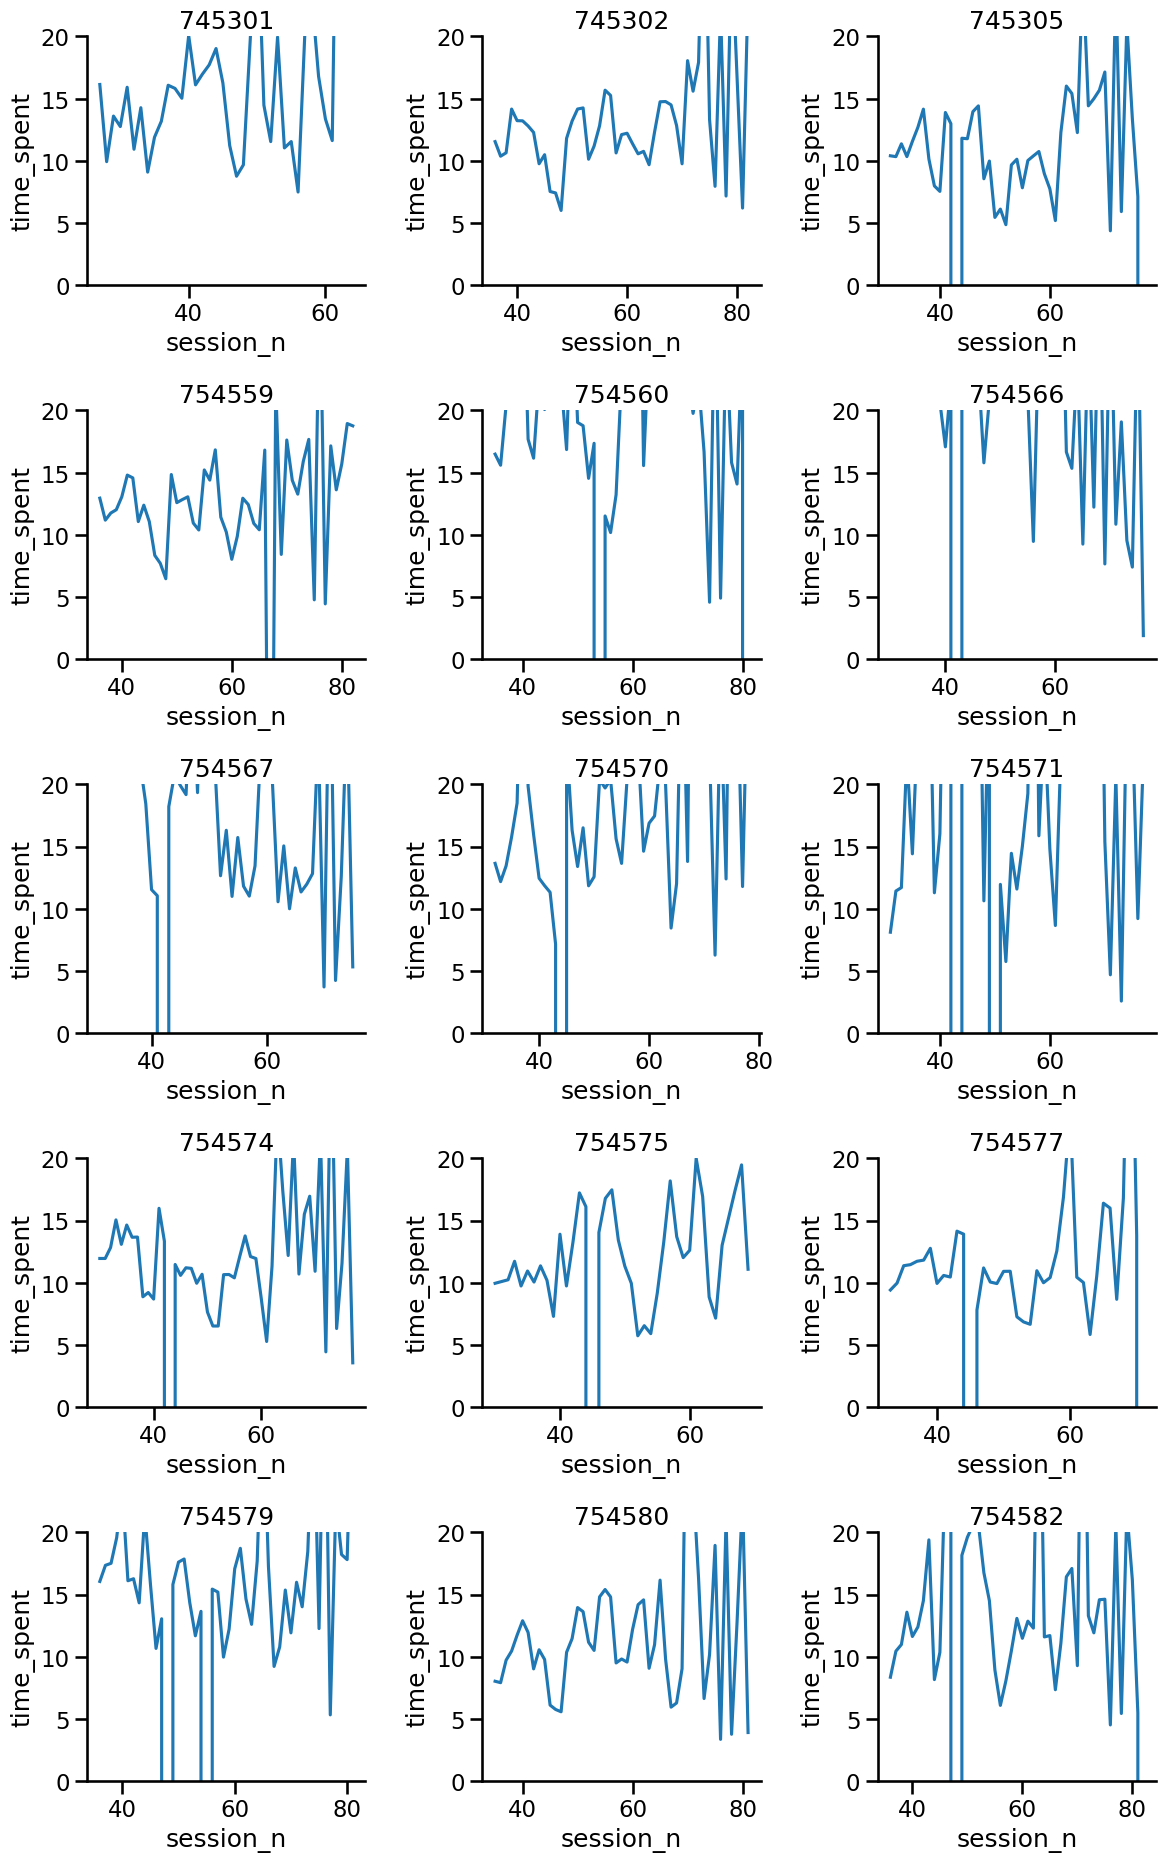

In [64]:
df = test_df.groupby(['mouse','session_n']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 3, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_n', y='time_spent', markers=True)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,20)
plt.tight_layout()
plt.show()

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


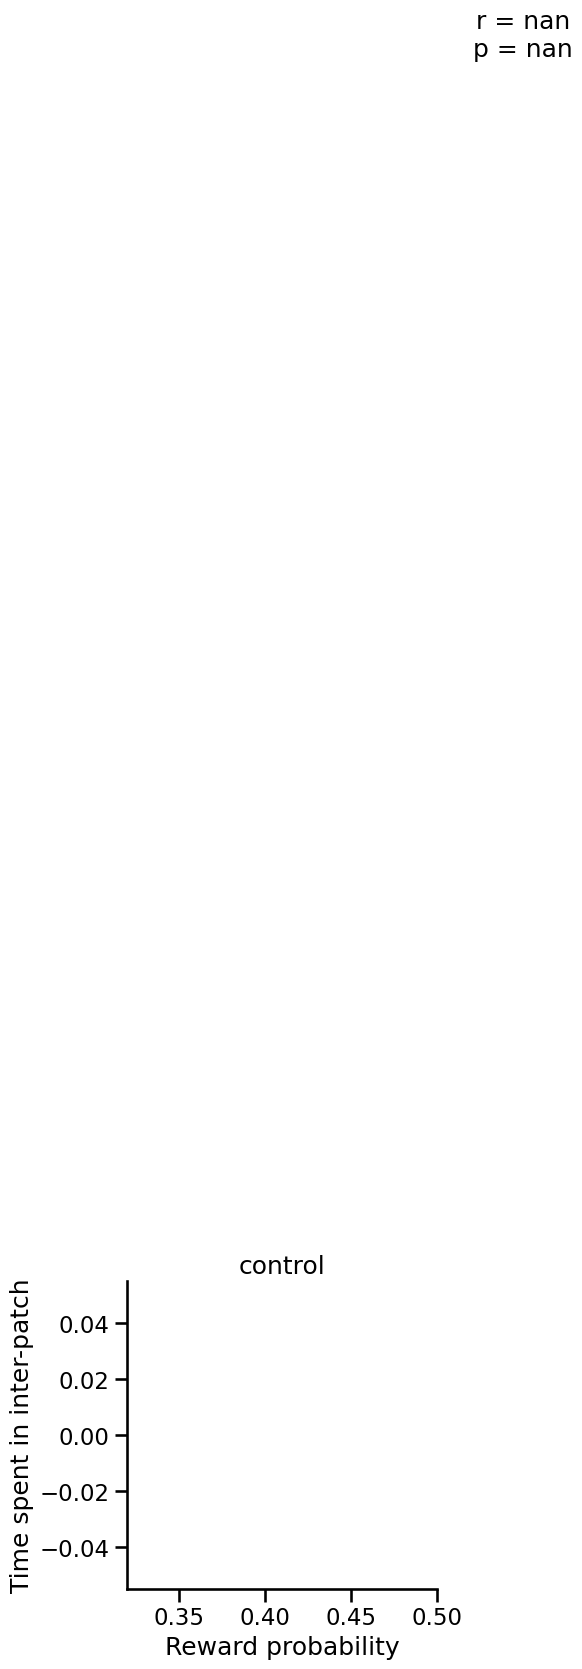

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


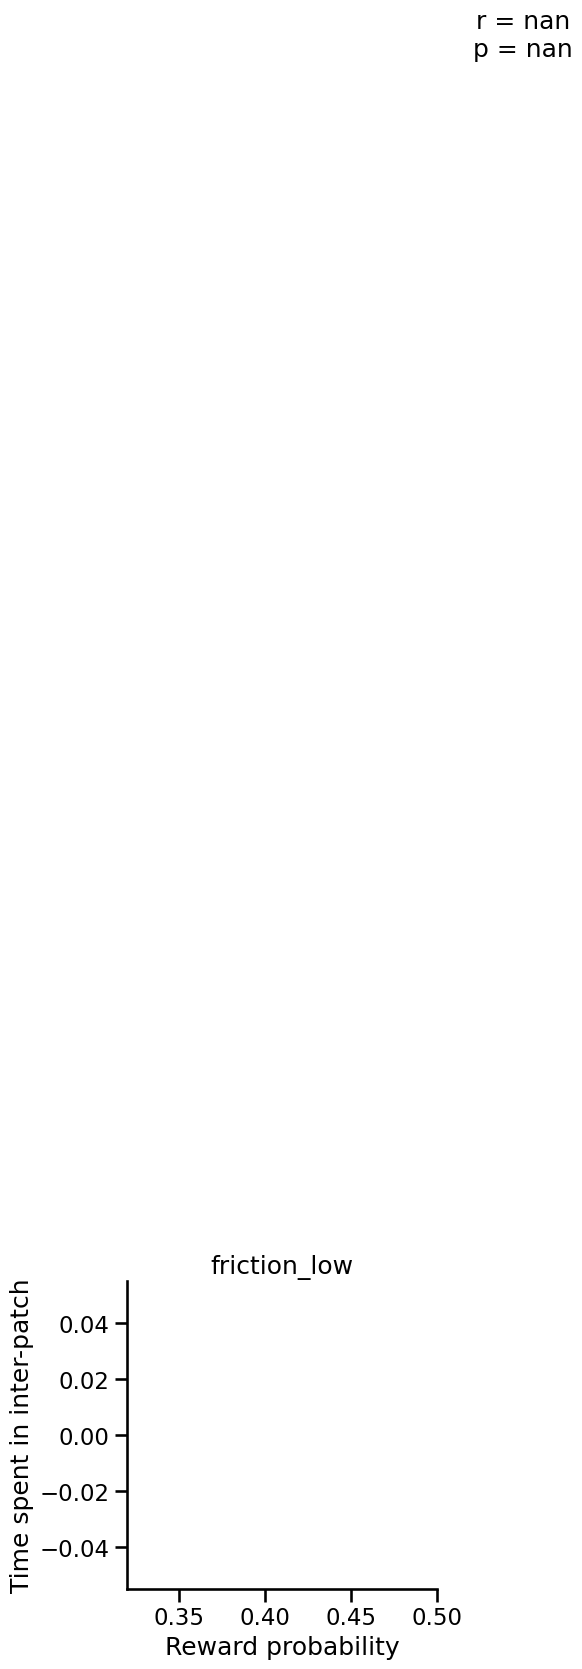

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


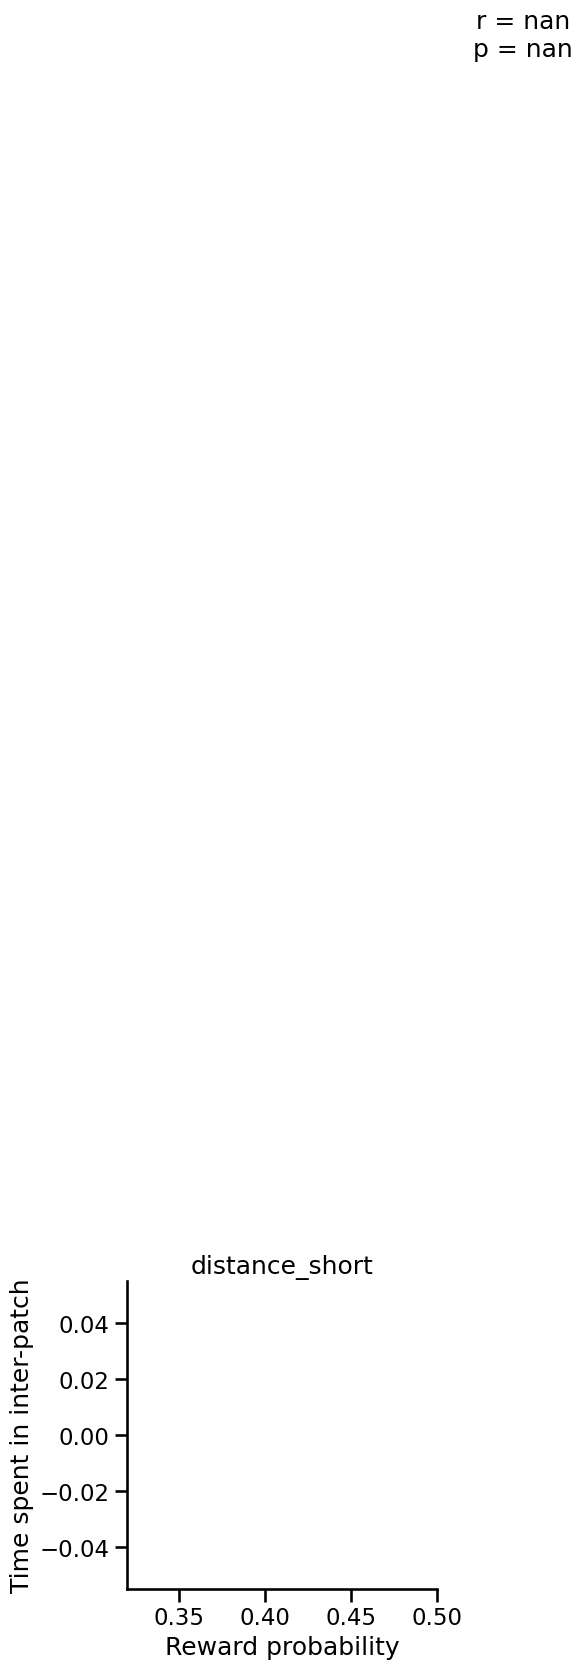

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


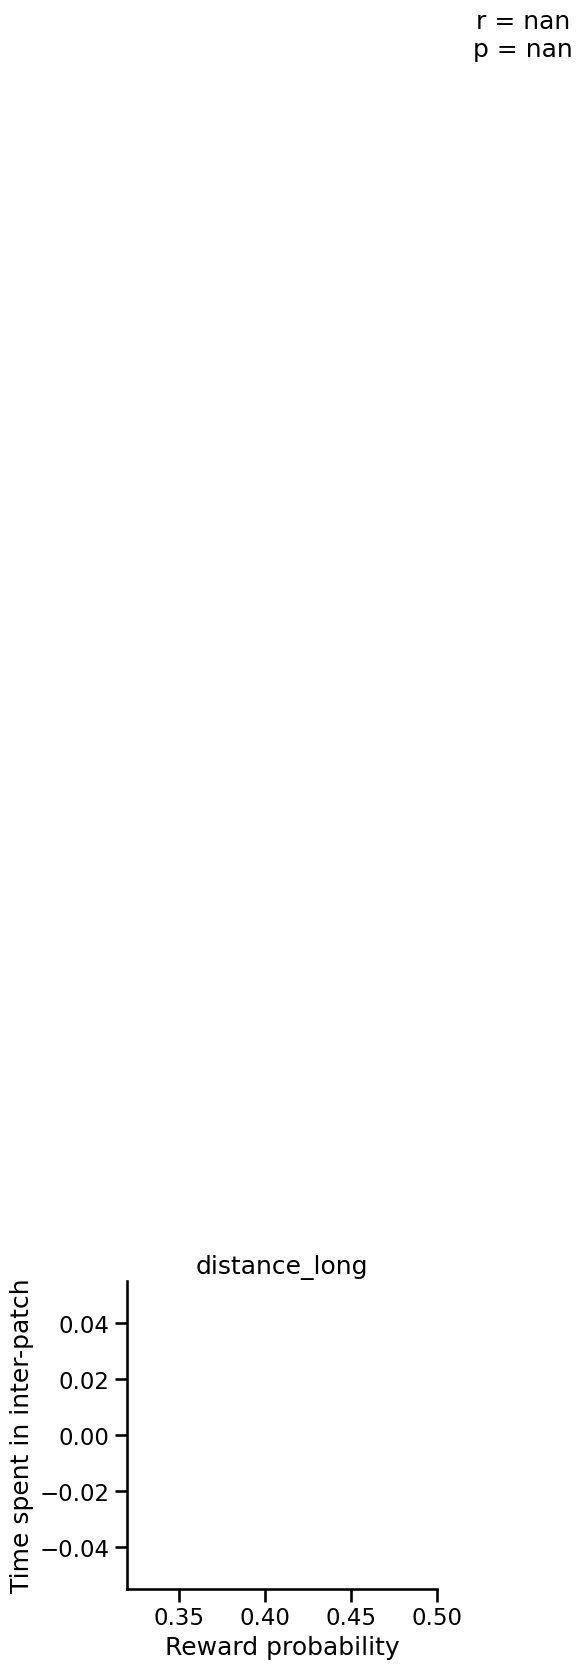

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


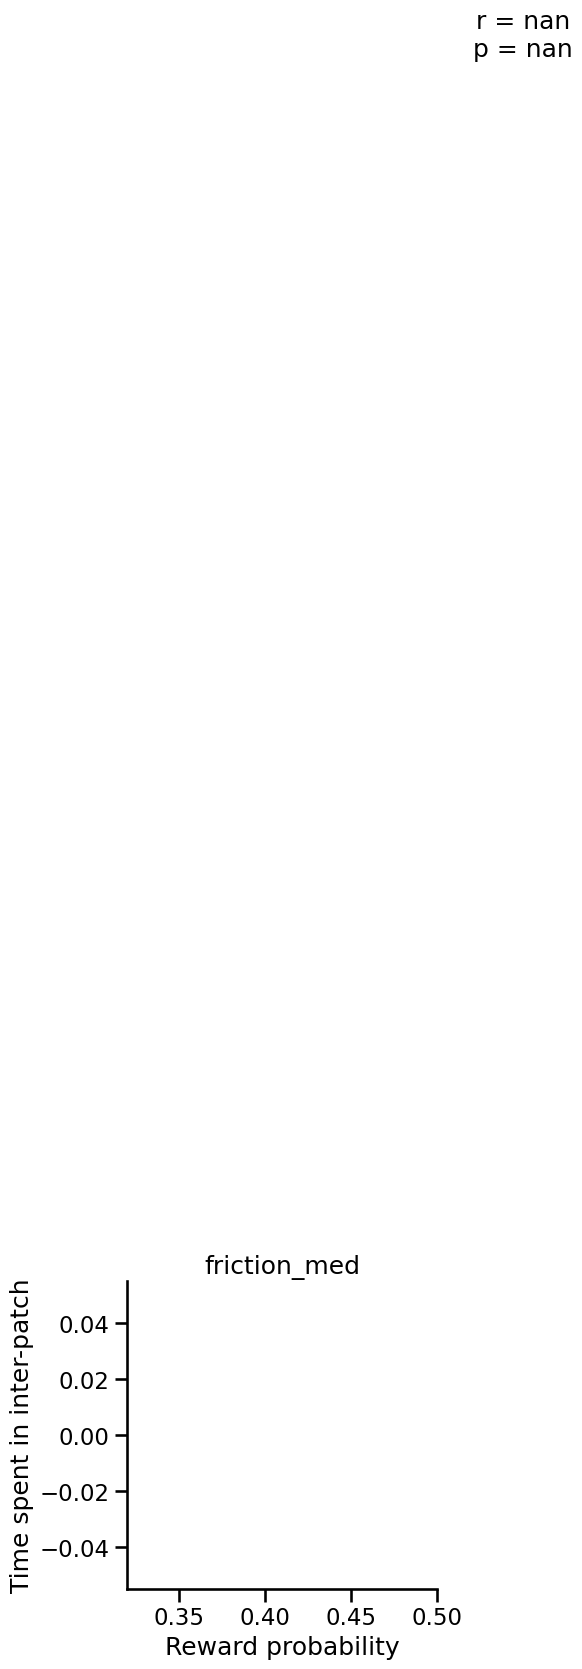

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


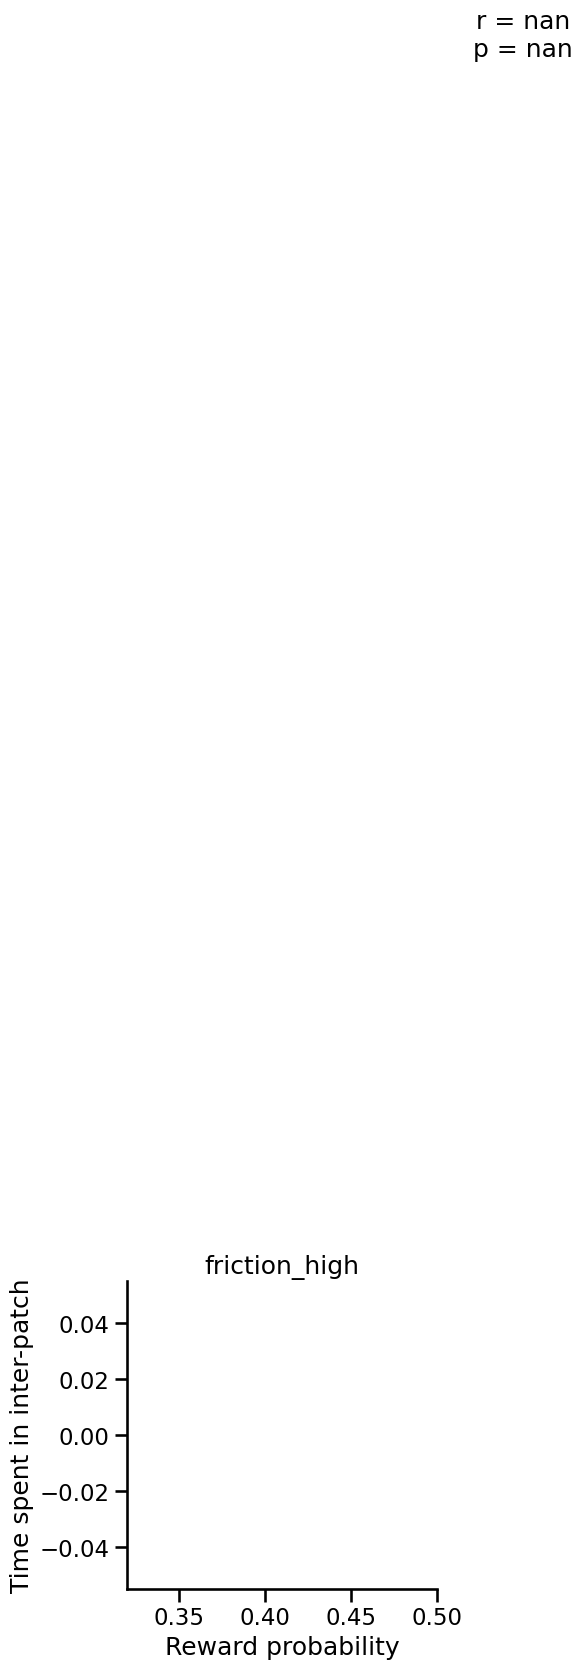

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


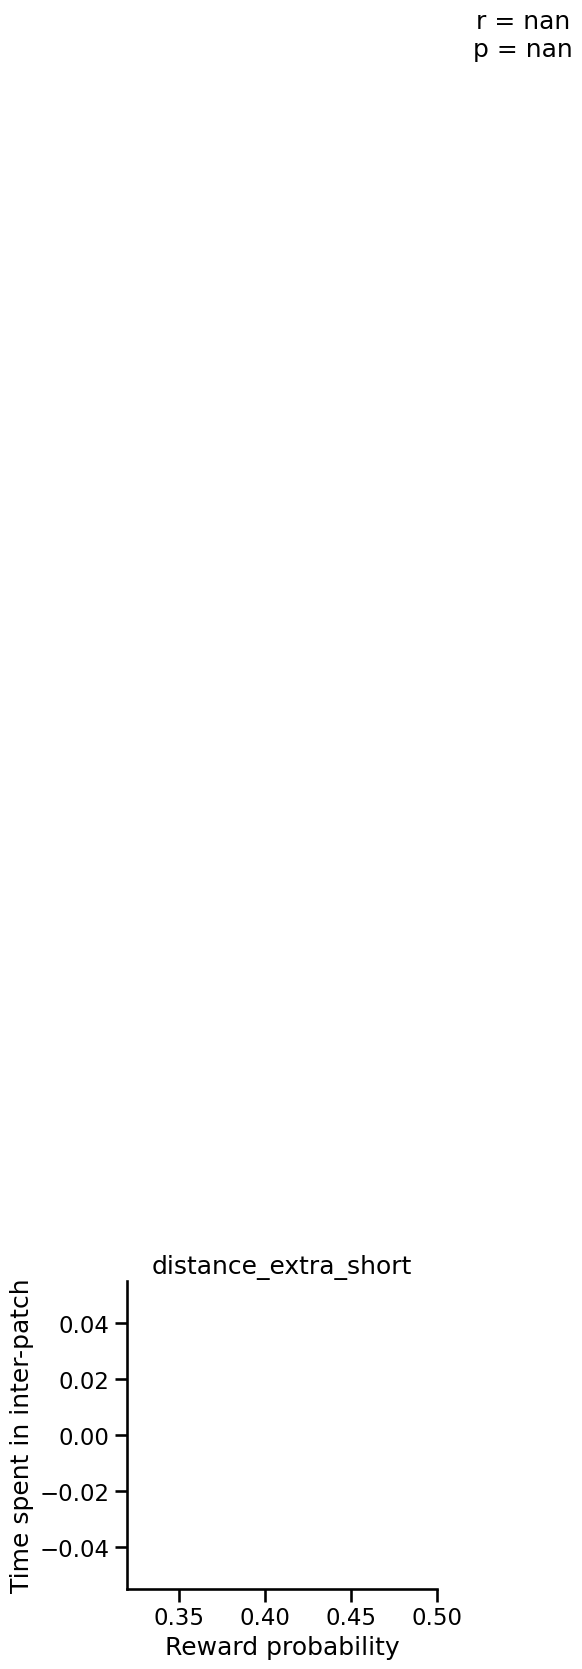

Correlation coefficient (pandas): nan
Correlation coefficient (scipy): nan
P-value: nan


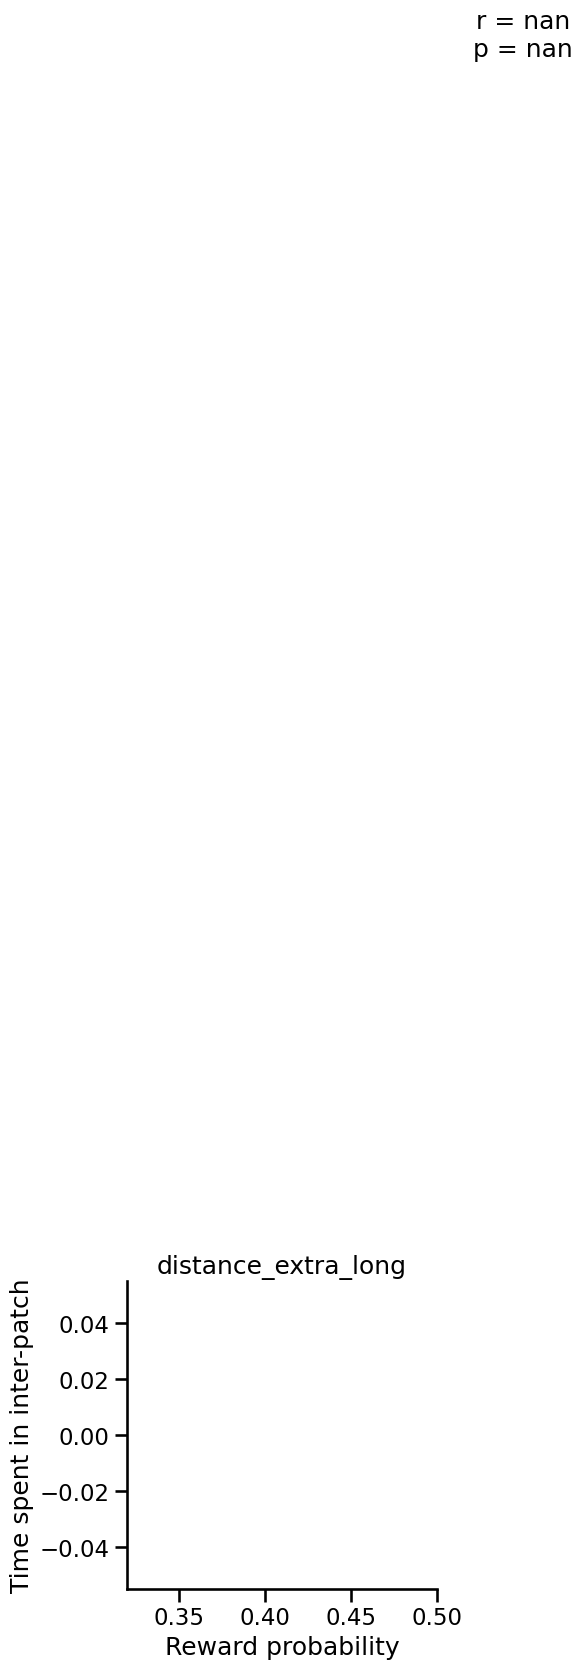

In [66]:
for experiment in summary_df.experiment.unique():
    test_df = summary_df.copy()
    test_df.set_index('Seconds', inplace=True)
    test_df = test_df.loc[test_df['label'] == 'InterPatch']
    test_df = test_df.groupby(['mouse', 'experiment', 'session_n'])['time_spent'].mean().reset_index()
    summary['time_spent'] = test_df.loc[test_df.experiment == experiment].groupby(['mouse']).time_spent.median().reset_index()['time_spent']

    # Assuming summary DataFrame is already defined
    # Calculate the correlation coefficient using pandas
    correlation_matrix = summary[['reward_probability', 'time_spent']].corr()
    correlation_coefficient = correlation_matrix.loc['reward_probability', 'time_spent']
    print(f"Correlation coefficient (pandas): {correlation_coefficient}")

    # Calculate the correlation coefficient and p-value using scipy
    correlation_coefficient, p_value = pearsonr(summary['reward_probability'], summary['time_spent'])
    print(f"Correlation coefficient (scipy): {correlation_coefficient}")
    print(f"P-value: {p_value}")

    fig = plt.figure(figsize=(4, 4))
    # Plot the regression plot
    sns.regplot(data=summary, x='reward_probability', y='time_spent', color='black')
    plt.text(0.55, 0.5, f"r = {correlation_coefficient:.3f}\np = {p_value:.3f}", ha='center', va='center')
    plt.xlabel('Reward probability')
    plt.ylabel('Time spent in inter-patch')
    plt.xlim(0.32, 0.5)
    plt.title(experiment)
    sns.despine()
    plt.show()
    # fig.savefig(results_path+f'/time_spent_vs_reward_probability.svg', dpi=300, bbox_inches='tight')

In [ ]:
df = summary_df.loc[summary_df.label == 'InterPatch'].groupby(['mouse','session_number', 'experiment']).time_spent.median().reset_index()
fig = plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='session_number', y='time_spent', hue='experiment', markers=True)
sns.despine()
plt.ylim(0,50)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
df = summary_df.groupby(['mouse','experiment','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
axes = []
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 3, i+1)
    sns.scatterplot(data=df.loc[df.mouse == mouse], x='session_number', y='time_spent', hue='experiment', markers=True, legend=False)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,6)
    axes.append(ax)
# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Experiment')
plt.tight_layout()
plt.show()

## Check if they respond different to the first failure depending on the odor

In [ ]:
cum_df = pd.DataFrame()
summary_df['next_has_choice'] = summary_df['has_choice'].shift(-1)
for mouse in summary_df.mouse.unique():
    for session_n,session in enumerate(summary_df[summary_df['mouse'] == mouse].session.unique()):
        for X in np.arange(0,3):
            # Filter for rows where reward_delivered is 0
            filtered_df = summary_df[(summary_df['reward_delivered'] == 0)&(summary_df.has_choice == 1)&(summary_df['odor_label'] != 'Amyl Acetate')
                                    &(summary_df['visit_number'] == X) & (summary_df['mouse'] == mouse)&(summary_df['session'] == session) &(summary_df['cumulative_failures'] == 0)]

            # Group by odor_labels and calculate the probability of next_has_choice being False
            probability_df = filtered_df.groupby('odor_label')['next_has_choice'].apply(lambda x: (x == False).mean()).reset_index()

            # Rename the columns for clarity
            probability_df.columns = ['odor_label', 'p_leaving']
            if len(probability_df) != 2:
                print('Not enough data points to calculate the probability of leaving')
                continue
            
            # Display the result
            probability_df['mouse'] = mouse
            probability_df['visit_number'] = X
            probability_df['session'] = session_n
            cum_df = pd.concat([cum_df, probability_df], axis=0)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(3, 10), sharex=True)
df_results = cum_df.groupby(['odor_label', 'visit_number', 'mouse'])['p_leaving'].mean().reset_index()
for i in range(0,3):
    sns.boxplot(data=df_results.loc[df_results.visit_number == i], x='odor_label', y='p_leaving', palette=color_dict_label, ax=ax[i], fliersize=0)

    for mouse in df_results.loc[df_results.visit_number == i].mouse.unique():
        y = df_results.loc[(df_results.mouse == mouse)&(df_results.visit_number == i)].p_leaving.values
        x = df_results.loc[(df_results.mouse == mouse)&(df_results.visit_number == i)].odor_label.values
        ax[i].plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)
        
    ax[i].set_ylabel('Probability \nof leaving')
    ax[i].set_title(f'Visit {i+1}')
    ax[i].set_ylim(0,0.8)
plt.xticks(rotation=45)
sns.despine()
plt.show()

## Experienced curves across experiments

**Average across experiments per mouse**

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        fig, ax = plt.subplots(1,3,figsize=(13, 5))
        i = 0
        # for odor in dict_odor.keys():
        for odor in summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)].odor_label.unique():

            odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
            odor_df = odor_df.loc[(odor_df.visit_number_count >= 3.0)]

            sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
            
            if odor_df.empty:
                i +=1
                continue
            
            # Plot exponential curve
            popt, pcov = curve_fit(exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

            ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
            ax[i].set_ylim(-0.1,1.1)
            ax[i].set_title(odor)
            ax[i].set_xlabel('Total rewarded stops in patch')
            ax[i].set_ylabel('Percent Rewarded')

            i +=1

        sns.despine()
        plt.suptitle(f'{mouse} {experiment}')
        plt.tight_layout()
        plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


**Average per mouse**

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    i=0
    extra = 0.0
    fig, ax = plt.subplots(1,6,figsize=(24, 5))
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        # for odor in dict_odor.keys():
        odor_df = summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
        odor_df = odor_df.loc[(odor_df.odor_label != 'Amyl Acetate')&(odor_df.odor_label != 'Fenchone')]
        odor_df = odor_df.loc[(odor_df.visit_number_count >= 5.0)]

        sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', hue='odor_label', palette=color_dict_label, ax=ax[i])
    
        # Plot exponential curve
        extra = 0
        for odor in odor_df.odor_label.unique():
            extra += 0.08
            popt, pcov = curve_fit(exponential_func, odor_df.loc[(odor_df['odor_label'] == odor)]['cumulative_rewards'],odor_df.loc[(odor_df['odor_label'] == odor)]['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color=dict_odor[odor]['color'], label='Exponential Fit', alpha=0.5)
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.8+extra, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color=dict_odor[odor]['color'], fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

        ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
        ax[i].set_ylim(-0.1,1.1)
        ax[i].set_title(experiment)
        ax[i].set_xlabel('Total rewarded stops in patch')
        ax[i].set_ylabel('Percent Rewarded')

        i +=1
        
    sns.despine()
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


## During session  p(reward) leave values

**Within session estimation of p(reward)**

In [ ]:
for mouse_df in summary_df.groupby(['mouse']):
    mouse = mouse_df[1].mouse.unique()[0]
    for session_df in mouse_df[1].groupby(['session']):
        session = session_df[1].session.unique()[0]
        session_df = session_df[1]
        
        fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)

        df = session_df.loc[(session_df.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        df['visit_number'] = session_df.loc[(session_df.has_choice == True)].groupby(['active_patch', 'odor_label']).agg({'visit_number':'count'})['visit_number'].values[:len(df)]
        df = df.loc[df['visit_number']>1]
        if df.empty:
            continue
        
        sns.scatterplot(x='active_patch', y='perceived_reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[0], legend=False)
        ax[0].set_ylabel('Perceived reward probability')
        ax[0].set_xlabel('Patch number')
        ax[0].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(0.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.perceived_reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05

        # Same for the perceived reward probability
        df = session_df.loc[(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min', 'visit_number':'count'}).reset_index()
        df['visit_number'] += 1
        df = df.loc[df['visit_number']>2]

        sns.scatterplot(x='active_patch', y='reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[1])
        ax[1].set_ylabel('Reward probability')
        ax[1].set_xlabel('Patch number')
        ax[1].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(1.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05
        
        plt.legend(bbox_to_anchor=(1.0,0.8), loc='upper left', labels=[max(df.visit_number)], markerscale=1.3, title='# visits')
        plt.suptitle(f'{mouse} {session} - {session_df.experiment.unique()[0]} - {session_df.session_number.unique()[0]}')
        sns.despine()
        plt.show()


In [ ]:
with PdfPages(os.path.join(results_path, 'across_sessions_parameters_batch4.pdf')) as pdf:
    for mouse_df in summary_df.groupby(['mouse']):
        mouse = mouse_df[1].mouse.unique()[0]
        for session_df in mouse_df[1].groupby(['session']):
            session = session_df[1].session.unique()[0]
            session_df = session_df[1]
            fig, ax = plt.subplots(3,1,figsize=(12,14), sharex=True)

            reward_sites = summary_df.loc[(summary_df['session'] == session)&(summary_df['mouse'] == mouse)&(summary_df['label'] == 'RewardSite')]

            patch_number = len(reward_sites.active_patch.unique())
            number_odors = len(reward_sites['odor_label'].unique())

            list_odors = []
            for odor in reward_sites.odor_label.unique():
                list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
            grid = (np.array(list_odors)/patch_number)*number_odors

            for index, row in reward_sites.iterrows():
                if row['reward_delivered'] == 1 and row['has_choice'] == True:
                    color='steelblue'
                elif row['reward_delivered'] == 0 and row['has_choice'] == True:
                    color='pink'
                    if row['reward_available'] == 0:
                        color='crimson'
                else:
                    if  row['reward_available'] == 0:
                        color='black'
                        hatch = '/'
                    else:
                        color='lightgrey'
                    
                ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
                ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
                ax[0].set_xlim(-1,50)
                ax[0].set_xlabel('Patch number')
                ax[0].set_ylabel('Site number')
                
                # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
                ax[0].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)
                ax[1].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)

            odors = []
            for index, odor in enumerate(reward_sites['odor_label'].unique()):
                odors.append(mpatches.Patch(color=color_dict_label[odor], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

            label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
            label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
            label_4 = mpatches.Patch(color='lightgrey', label='Leave')

            odors.extend([label_2, label_3,label_4])
            plt.legend(handles=odors, loc='right', bbox_to_anchor=(0.75, 1), fontsize=12, ncol=2)
            ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

            summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
            summary.reset_index(inplace=True)

            sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None, legend=False)
            for p in ax[1].patches:
                ax[1].annotate(f'{int(p.get_height())}',  # The count
                            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                            ha='center', va='center', 
                            xytext=(0, 9), fontsize=9,  # 9 points vertical offset
                            textcoords='offset points')
            sns.barplot(x='active_patch', y='reward_delivered', hue='odor_label', palette= color_dict_label, data=summary, legend=False, ax=ax[1], errorbar=None)

            # Specifying the number of xticks
            num_ticks = 10  # Change this to the desired number of ticks
            xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

            # Specifying the xticks
            ax[1].set_xticks(xticks)
            # ax[1].set_xlim(-1,125)
            ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
            ax[1].set_ylabel('Site number')

            df = session_df.loc[(session_df.last_site == 1)&(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min','visit_number':'mean'}).reset_index()
            # sns.scatterplot(x='active_patch', y='reward_probability', color='b', s=50, marker='o',  zorder=10, hue='odor_label', palette=color_dict_label, data = df, ax = ax[2], legend=False)
            # sns.lineplot(x='active_patch', y='reward_probability', marker='',color='grey', alpha=0.5, data = df, ax = ax[2], legend=False)
            
            sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax[2], legend=False)
            
            ax[2].set_xlabel('Patch number')
            ax[2].set_ylabel('P(reward) when leaving')            
            ax[2].set_ylim(-0.1,1.1)
            
            plt.suptitle(f'{mouse} {session} - session {session_df.session_number.unique()[0]} - {session_df.experiment.unique()[0]}')
            sns.despine()
            plt.tight_layout()
            plt.show()
            pdf.savefig(fig)


## Does the friction correlate with the time in the patch?

In [ ]:
simplified_df = session_df.groupby(['mouse', 'session_n','experiment']).agg({'reward_probability': 'mean', 'friction': 'mean', 'stops': 'mean'}).reset_index()

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

sns.scatterplot(x='stops', y='friction', data=simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high')], ax=ax, legend=False)
sns.regplot(x='stops', y='friction', data=simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high')], ax=ax, scatter=False, color='red')
plt.ylim(0,30)
# Fit a linear regression model
X = simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high'), 'stops']
y = simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high'), 'friction']
X = sm.add_constant(X)  # Add a constant term for the intercept
model = sm.OLS(y, X).fit()
coef = model.params
r2 = model.rsquared
p_value = model.pvalues[1]  # p-value for the slope coefficient

ax.text(0.1, 0.8, f'y = {coef[1]:.2f}x + {coef[0]:.2f}\n$R^2$ = {r2:.2f}\np = {p_value:.3f}', transform=ax.transAxes, color='red', fontsize=8)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=True, sharey=True)

for ax, mouse in zip(axes.flatten(), simplified_df.mouse.unique()):
    loop_df = simplified_df.loc[simplified_df.mouse == mouse]
    ax.set_title(mouse)
    sns.scatterplot(x='reward_probability', y='friction', data=loop_df.loc[(loop_df.experiment=='friction_low')|(loop_df.experiment=='friction_med')|(loop_df.experiment=='friction_high')], ax=ax, legend=False)
    sns.regplot(x='reward_probability', y='friction', data=loop_df.loc[(loop_df.experiment=='friction_low')|(loop_df.experiment=='friction_med')|(loop_df.experiment=='friction_high')], ax=ax, scatter=False, color='red')
    
    # Fit a linear regression model
    X = loop_df.loc[(loop_df.experiment=='friction_low')|(loop_df.experiment=='friction_med')|(loop_df.experiment=='friction_high'), 'reward_probability']
    y = loop_df.loc[(loop_df.experiment=='friction_low')|(loop_df.experiment=='friction_med')|(loop_df.experiment=='friction_high'), 'friction']
    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X).fit()
    coef = model.params
    r2 = model.rsquared
    p_value = model.pvalues[1]  # p-value for the slope coefficient
    
    ax.text(0.1, 0.8, f'y = {coef[1]:.2f}x + {coef[0]:.2f}\n$R^2$ = {r2:.2f}\np = {p_value:.3f}', transform=ax.transAxes, color='red', fontsize=8)
    
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

ax.set_title(mouse)
sns.scatterplot(x='reward_probability', y='friction', data=simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high')], ax=ax, legend=False)
sns.regplot(x='reward_probability', y='friction', data=simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high')], ax=ax, scatter=False, color='red')
plt.ylim(0,30)
# Fit a linear regression model
X = simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high'), 'reward_probability']
y = simplified_df.loc[(simplified_df.experiment=='friction_low')|(simplified_df.experiment=='friction_med')|(simplified_df.experiment=='friction_high'), 'friction']
X = sm.add_constant(X)  # Add a constant term for the intercept
model = sm.OLS(y, X).fit()
coef = model.params
r2 = model.rsquared
p_value = model.pvalues[1]  # p-value for the slope coefficient

ax.text(0.1, 0.8, f'y = {coef[1]:.2f}x + {coef[0]:.2f}\n$R^2$ = {r2:.2f}\np = {p_value:.3f}', transform=ax.transAxes, color='red', fontsize=8)
sns.despine()
plt.tight_layout()
plt.show()